[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/CMU-IDeeL/CMU-IDeeL.github.io/blob/master/F25/document/Recitation_0_Series/0.13/0_13_Data_Preprocessing_Part_2.ipynb)

##Image data preprocessing

In [9]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#### **Data loading (We will use some open source images from Lorem Picsum)**

In [10]:
# !rm -r lorem_data
!mkdir lorem_data
!mkdir lorem_data/lorem_data1
!mkdir lorem_data/lorem_data2
!mkdir lorem_data/lorem_data3
!curl -o lorem_data/lorem_data1/sample1.jpg https://fastly.picsum.photos/id/22/4434/3729.jpg?hmac=fjZdkSMZJNFgsoDh8Qo5zdA_nSGUAWvKLyyqmEt2xs0
!curl -o lorem_data/lorem_data2/sample2.jpg https://fastly.picsum.photos/id/16/2500/1667.jpg?hmac=uAkZwYc5phCRNFTrV_prJ_0rP0EdwJaZ4ctje2bY7aE
!curl -o lorem_data/lorem_data3/sample3.jpg https://fastly.picsum.photos/id/64/4326/2884.jpg?hmac=9_SzX666YRpR_fOyYStXpfSiJ_edO3ghlSRnH2w09Kg


zsh:1: no matches found: https://fastly.picsum.photos/id/22/4434/3729.jpg?hmac=fjZdkSMZJNFgsoDh8Qo5zdA_nSGUAWvKLyyqmEt2xs0
zsh:1: no matches found: https://fastly.picsum.photos/id/16/2500/1667.jpg?hmac=uAkZwYc5phCRNFTrV_prJ_0rP0EdwJaZ4ctje2bY7aE
zsh:1: no matches found: https://fastly.picsum.photos/id/64/4326/2884.jpg?hmac=9_SzX666YRpR_fOyYStXpfSiJ_edO3ghlSRnH2w09Kg


It is easy when working with images of same dimensions. Hence we will resize the downloaded images. This could be done using a pytorch resize transformation but here we will use a function to do it so we can appreciate how learning about the available transformations in pytorch can help save you time.

In [11]:
from PIL import Image
import os

# Function to resize an image
def resize_image(input_path, output_path, size):
    try:
        img = Image.open(input_path)
        img = img.resize(size, Image.Resampling.LANCZOS) #LANCZOS Resampling: This is a high-quality filter useful for resizing images without significant loss of quality.
        img.save(output_path)
        print(f"Resized {input_path} to {output_path}")
    except Exception as e:
        print(f"Error resizing {input_path}: {e}")

# Define the directories containing the images
directories = [
    "./content/lorem_data/lorem_data1",
    "./content/lorem_data/lorem_data2",
    "./content/lorem_data/lorem_data3",
]

# Size for resizing
new_size = (224, 224)

for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            input_path = os.path.join(directory, filename)
            output_path = os.path.join(directory, filename)
            resize_image(input_path, output_path, new_size)


Resized ./content/lorem_data/lorem_data1/sample1.jpg to ./content/lorem_data/lorem_data1/sample1.jpg
Resized ./content/lorem_data/lorem_data2/sample2.jpg to ./content/lorem_data/lorem_data2/sample2.jpg
Resized ./content/lorem_data/lorem_data3/sample3.jpg to ./content/lorem_data/lorem_data3/sample3.jpg


#### **EDA and Viz**

In [12]:
DATA_DIR   = './content/lorem_data/'

## Pytorch simplifies the creation of image datasets
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=torchvision.transforms.ToTensor()) # We apply a transform toTensor which converts the images to pytorch tensors

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [3, 3729, 4434] at entry 1

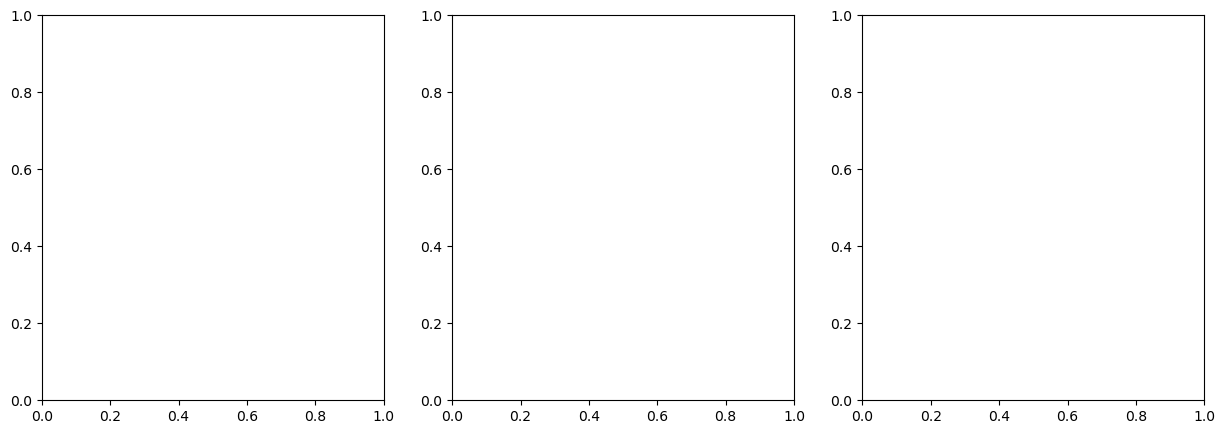

In [13]:
## A snapshot of the data without any transformation or normalization
r, c = [1, 3]
fig, ax = plt.subplots(r, c, figsize=(15, 5))  \

k = 0
dtl_pure = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=3,)

for data in dtl_pure:
    x, y = data
    for j in range(c):
        img = x[k].numpy().transpose(1, 2, 0)
        ax[j].imshow(img)  # Adjusted indexing for one-dimensional ax
        ax[j].axis('off')
        k += 1
        if k >= 3:  # Break the loop after 3 images
            break
    break  # This will only execute the outer loop once

#### **Data transformation**

Here, we'll apply normalization and standardization to the images.

This code defines a helper function that computes the mean and standard deviation for each channel (e.g., Red, Green, Blue) of all images in a dataset, which is crucial for image normalization in deep learning workflows.

In [6]:
#Here is a helper function to calculate the mean and standard deviation of the images
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in dataloader:
        # Sum over all batches, height, and width; keep the channel dimension
        channels_sum += torch.sum(data, dim=[0, 2, 3])
        channels_squared_sum += torch.sum(data ** 2, dim=[0, 2, 3])
        num_batches += data.shape[0]  # Add the batch size

    mean = channels_sum / (num_batches * dataloader.dataset[0][0].size(1) * dataloader.dataset[0][0].size(2))

    std = (channels_squared_sum / (num_batches * dataloader.dataset[0][0].size(1) * dataloader.dataset[0][0].size(2)) - mean ** 2) ** 0.5

    return mean, std

Normalization ensures each image channel has consistent intensity statistics across the dataset. This removes variations in lighting and contrast, helping neural networks train more efficiently and converge faster.

Means:  tensor([0.5939, 0.6290, 0.6131])
std_dev:  tensor([0.2375, 0.2042, 0.1834])


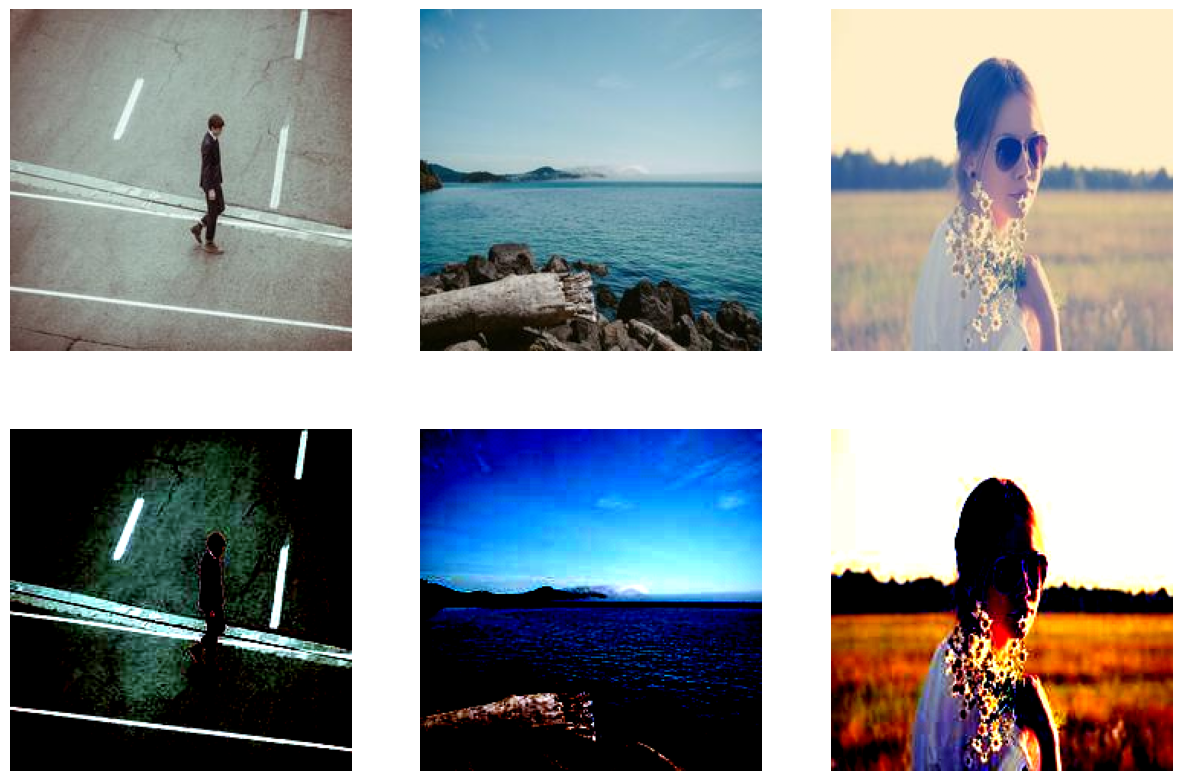

In [7]:
# Define normalization transforms:
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=3)
mean, std = get_mean_and_std(data_loader)
print("Means: ", mean)
print("std_dev: ", std)
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),])
r, c = [2, 3]
fig, ax = plt.subplots(r, c, figsize=(15, 10))
# Apply normalization to both training and test datasets:
dtl_norm = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(DATA_DIR, transform=normalize_transform),
    batch_size=3,)

# Display images from dtl_pure
for data in dtl_pure:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[0, j].imshow(img)
        ax[0, j].axis('off')
    break  # Only take the first batch

# Display images from dtl_norm
for data in dtl_norm:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[1, j].imshow(img)
        ax[1, j].axis('off')
    break  # Only take the first batch

#### **Data augmentation**

In this section, we'll apply data augmentation techniques to the training dataset.

How to apply them to our image dataset:

URL:
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py \
Common Issue: \
```TypeError: Input tensor should be a torch tensor. Got <class
'PIL.Image.Image'>.``` \
—> Please check the sequencing of your transforms. Read the documentation and verify
the kind of input required.

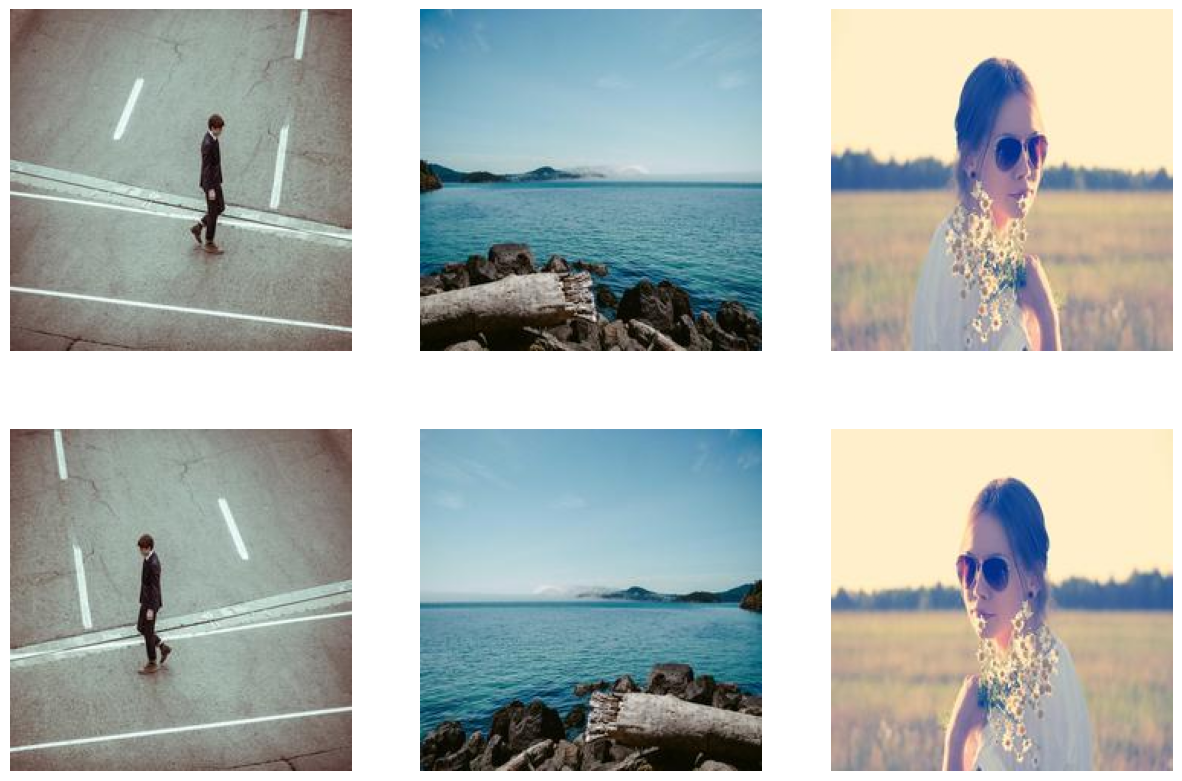

In [8]:
# Apply data augmentation to the training dataset:

horiz_flip_transform = torchvision.transforms.Compose([
                    # transforms.Resize((224, 224)), # Ensures that the images are resized to 224x224
                    transforms.RandomHorizontalFlip(p=1), # Flips the image horizontally randomly with a probability of 100%
                    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # Randomly changes the brightness, contrast, saturation, and hue
                    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation of the image keeping center invariant
                    transforms.ToTensor(), # Converts the image to a PyTorch tensor
                    ])

r, c = [2, 3]
fig, ax = plt.subplots(r, c, figsize=(15, 10))
# Apply normalization to both training and test datasets:
dtl_hori_flip = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(DATA_DIR, transform=horiz_flip_transform),
    batch_size=3,)

# Display images from dtl_pure
for data in dtl_pure:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[0, j].imshow(img)
        ax[0, j].axis('off')
    break  # Only take the first batch

# Display images from dtl_norm
for data in dtl_hori_flip:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[1, j].imshow(img)
        ax[1, j].axis('off')
    break  # Only take the first batch

Multiple augmentation strategies can be  combined

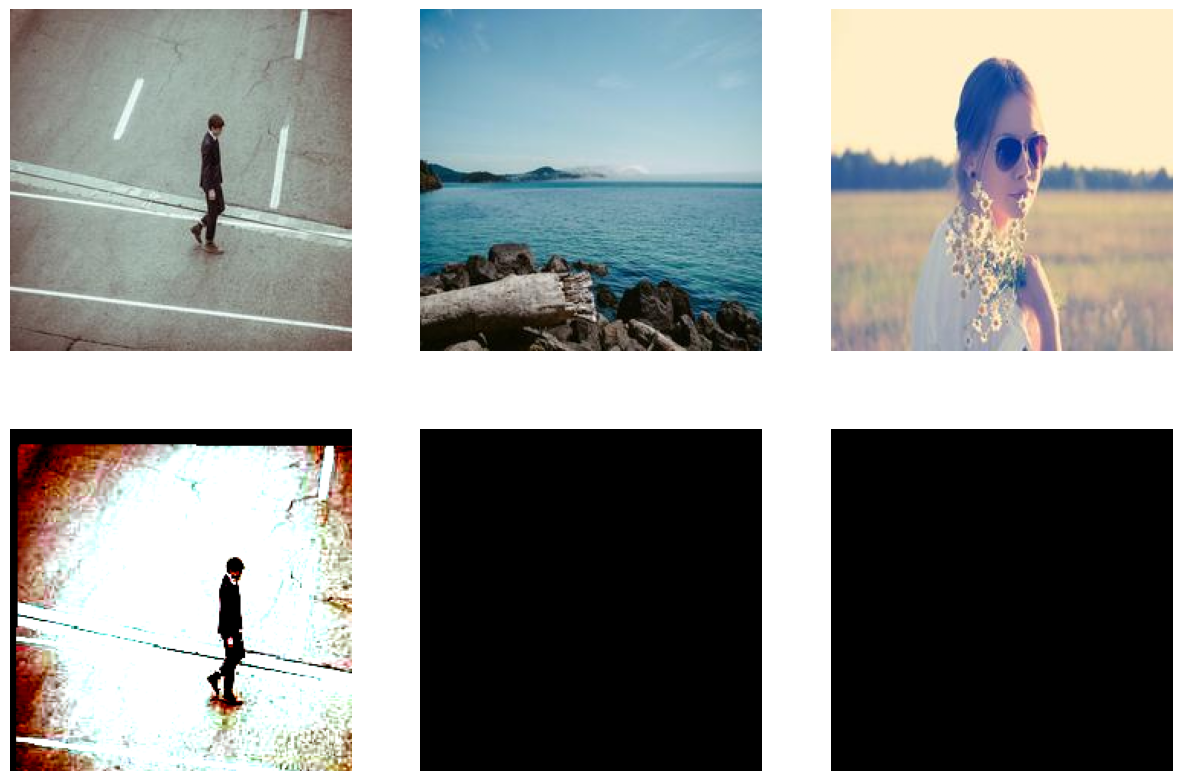

In [9]:
# Apply data augmentation:

combine_transform = torchvision.transforms.Compose([
                    transforms.Resize((224, 224)), # Ensures that the images are resized to 224x224
                    transforms.RandomHorizontalFlip(p=0.5), # Flips the image horizontally randomly with a probability of 50%
                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # Randomly changes the brightness, contrast, saturation, and hue
                    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation of the image keeping center invariant
                    transforms.ToTensor(), # Converts the image to a PyTorch tensor
                    transforms.Normalize(mean=mean, std=std)
                    ])

r, c = [2, 3]
fig, ax = plt.subplots(r, c, figsize=(15, 10))
# Apply combination of transfroms :
combined_dtl = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(DATA_DIR, transform=combine_transform),
    batch_size=3,)

# Display images from dtl_pure
for data in dtl_pure:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[0, j].imshow(img)
        ax[0, j].axis('off')
    break  # Only take the first batch

# Display images from dtl_norm
for data in combined_dtl:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[1, j].imshow(img)
        ax[1, j].axis('off')
    break  # Only take the first batch

Not all augmentations are valid, you should understand the problem you are trying to solve and self evaluate if the augmentation you are applying will help. For example it does not make sense to do a vertical flip in a facial recognition problem except.

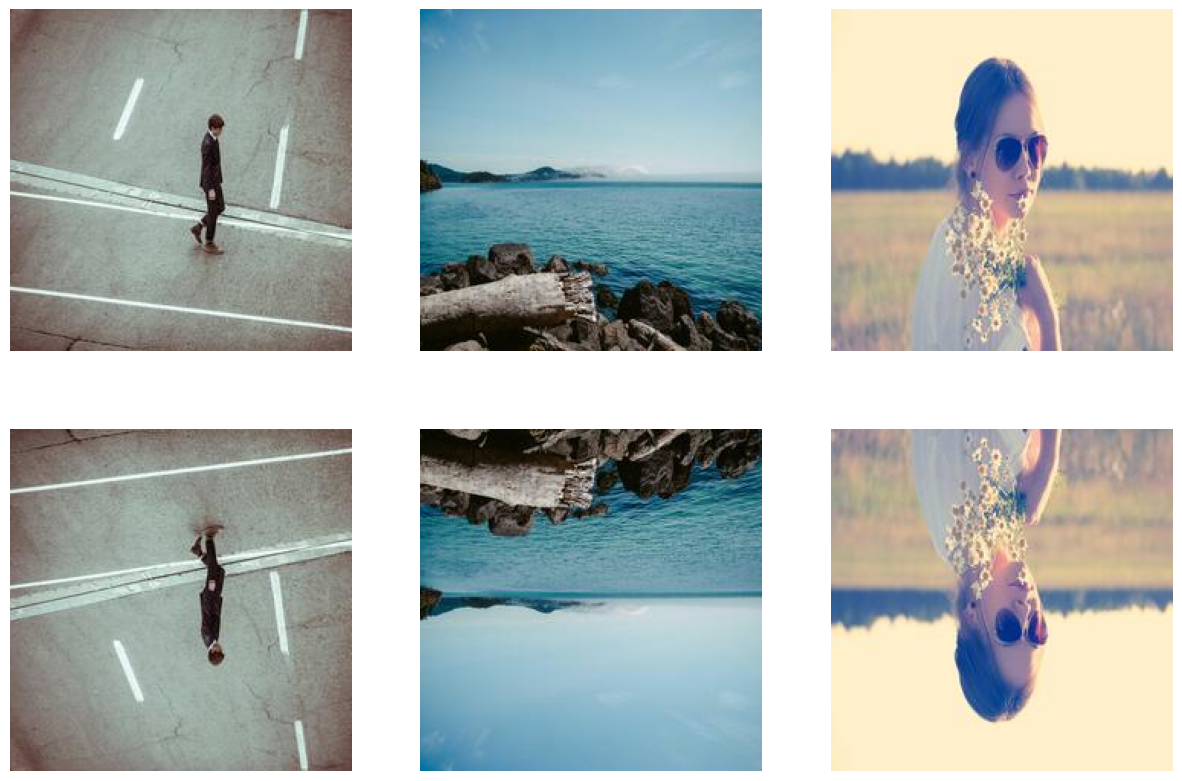

In [10]:
# Apply data augmentation to the training dataset:

vert_flip_transform = torchvision.transforms.Compose([
                    # transforms.Resize((224, 224)), # Ensures that the images are resized to 224x224
                    transforms.RandomVerticalFlip(p=1), # Flips the image horizontally randomly with a probability of 100%
                    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # Randomly changes the brightness, contrast, saturation, and hue
                    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation of the image keeping center invariant
                    transforms.ToTensor(), # Converts the image to a PyTorch tensor

                    ])

r, c = [2, 3]
fig, ax = plt.subplots(r, c, figsize=(15, 10))
# Apply vertical flipping augmentation:
dtl_vert_flip = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(DATA_DIR, transform=vert_flip_transform),
    batch_size=3,)

# Display images from dtl_pure
for data in dtl_pure:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[0, j].imshow(img)
        ax[0, j].axis('off')
    break  # Only take the first batch

# Display images from dtl_vert_flip
for data in dtl_vert_flip:
    x, y = data
    for j in range(c):
        img = x[j].numpy().transpose(1, 2, 0)
        ax[1, j].imshow(img)
        ax[1, j].axis('off')
    break  # Only take the first batch

### **4. Questions to self-test your understanding of pre-processing concepts**

**Q1: Why is the Mel Spectrogram a preferred feature over the raw spectrogram for audio processing tasks like speech recognition?**

Hint: Consider how human hearing perception varies across different frequency ranges and how the Mel scale is designed to mimic this aspect.

**Q2: What is the significance of applying frequency and time masking as data augmentation techniques in audio preprocessing?**

Hint: Reflect on the challenges a model might face when encountering variations in audio signals, and how masking certain time and frequency components can enhance model robustness.

**Q3: How does image augmentation with transformations like rotation and flipping benefit the training of neural networks, especially in computer vision tasks?**

Hint: Think about the variety and diversity of data that a model encounters in real-world scenarios, and how simulating these variations during training can affect a model's performance and generalization ability.

Thanks for reviewing this material!